In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


libgomp: Invalid value for environment variable OMP_NUM_THREADS
/home/user/conda/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/conda/envs/dl/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


PyTorch Version:  1.12.0+cu116
Torchvision Version:  0.13.0+rocm5.1.1
CUDA is available!  Training on GPU ...



libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [2]:
# import kaggle

# kaggle.api.authenticate()
# kaggle.api.dataset_download_files("alexattia/the-simpsons-characters-dataset")
# unzip

In [3]:
class SimpsonTrainValPath():
  def __init__(self):
    self.train_dir = Path('./simpsons_dataset')
    self.test_dir = Path('./kaggle_simpson_testset')
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):
    train_files_path, val_files_path = train_test_split(
      self.train_val_files_path,
      test_size = 0.15,
      stratify=self.train_val_labels
    )
    print(len(train_files_path), len(val_files_path))
    return train_files_path, val_files_path, self.test_path
  
  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))

In [4]:
simpsons_paths = SimpsonTrainValPath()
train_path, val_path, test_path = simpsons_paths.get_path()
n_classes = simpsons_paths.get_n_classes()
n_classes

35586 6280


42

In [5]:
class SimpsonsDataset(Dataset):
    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms
      
      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx]) 
      image = Image.open(img_path)
      image = self.transform(image)
      
      if 'test' in str(self.files_path[0]):
        return image
      
      label_str = str(self.files_path[idx].parent.name)
      label = self.label_encoder.transform([label_str]).item()
      return image, label

In [19]:
input_size = 128

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        # transforms.RandomChoice([ 
        #     transforms.RandomHorizontalFlip(p=0.5),
        #     transforms.ColorJitter(contrast=0.9),
        #     transforms.ColorJitter(brightness=0.1),
        # ]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
train_dataset = SimpsonsDataset(train_path, data_transforms['train'])
val_dataset = SimpsonsDataset(val_path, data_transforms['val'])
full_train_dataset = SimpsonsDataset(train_path + val_path, data_transforms['val'])
test_dataset = SimpsonsDataset(test_path, data_transforms['val'])

In [21]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=4
)
full_train_dataloader = torch.utils.data.DataLoader(
  full_train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=4
)
test_dataloader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size,
  shuffle=False,
  num_workers=4
)

In [22]:
def imshow(inp, title, ax):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.grid(False)

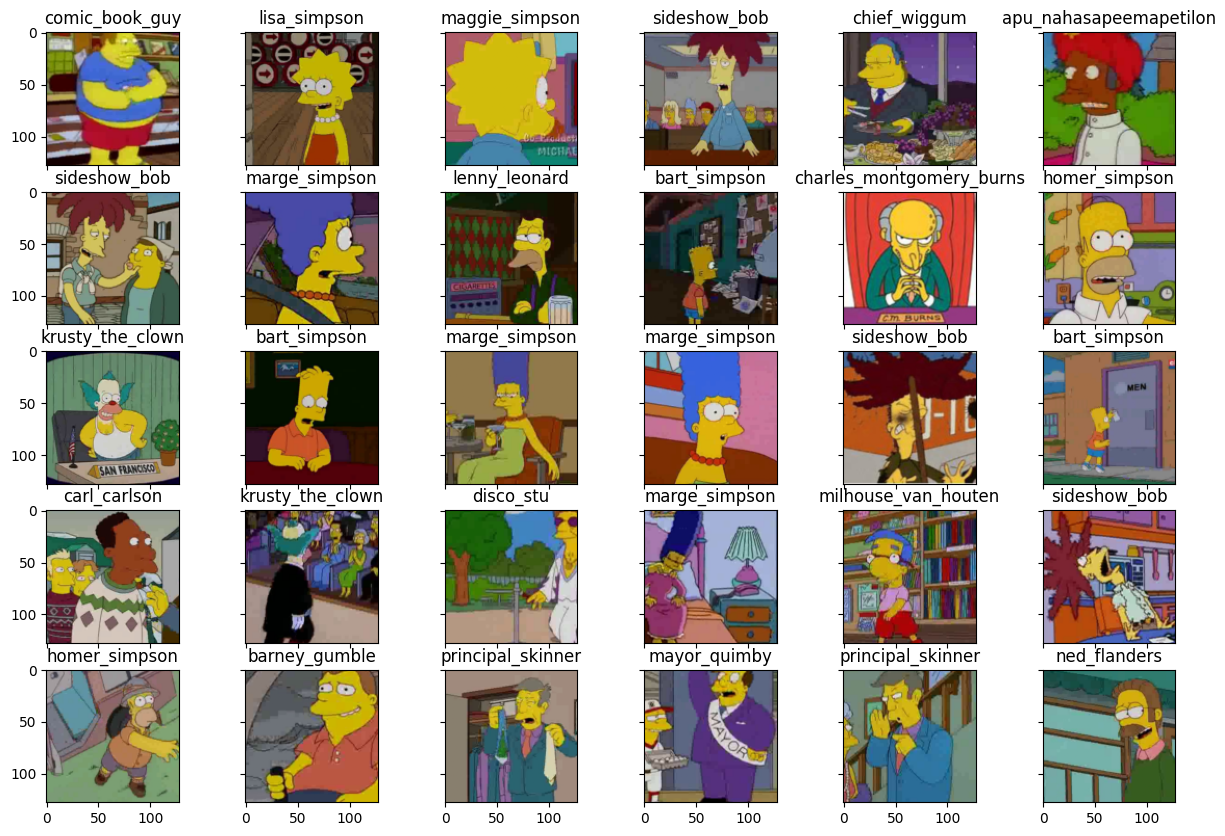

In [23]:
fig, ax = plt.subplots(
    nrows=5,
    ncols=6,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
)
for fig_x in ax.flatten():
    random_character = np.random.randint(0, len(train_dataset))
    im_val, label = train_dataset[random_character]
    img_label = train_dataset.label_encoder.inverse_transform([label]).item()
    imshow(im_val.data.cpu(), img_label, fig_x)

In [24]:
from collections import defaultdict
from time import perf_counter
from sklearn.metrics import f1_score, accuracy_score

@torch.no_grad()
def get_f1_score(data_loader, model: torch.nn.Module, device):
    model.eval()
    preds = []
    true = []
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())
        true.extend(labels.cpu().numpy())
    return f1_score(true, preds, average="weighted")

@torch.no_grad()
def validation_step(dataloader, model, device, loss_func):
    model.eval()
    validation_loss = []
    tp = 0
    sz = 0
    for images, labels in dataloader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        validation_loss.append(loss)
        _, predicted = torch.max(outputs.data, 1)
        tp += (predicted == labels).sum()
        sz += labels.size(0)
        
    mean_loss = torch.stack(validation_loss).mean().cpu().item()
    acc = tp.cpu().item() / sz
    return mean_loss, acc

def fit(
    model, 
    loss_function, 
    optimizer, 
    learning_rate, 
    num_epochs, 
    train_data_loader, 
    val_data_loader
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), lr=learning_rate)
    history = defaultdict(list)
    train_time = perf_counter()
    
    for epoch in range(num_epochs):
        train_loss = []
        epoch_time = time.perf_counter()
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            train_loss.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        epoch_time = time.perf_counter() - epoch_time
        train_loss = torch.stack(train_loss).mean().cpu().item()
        history["train_loss"].append(train_loss)
        validation_loss, validation_acc = validation_step(val_data_loader, model, device, loss_function)
        history["val_loss"].append(validation_loss)
        history["val_accuracy"].append(validation_acc)
        print(f"Epoch[{epoch}]: train_loss = {train_loss}, val_loss = {validation_loss}, val_acc = {validation_acc}, done in {epoch_time} seconds")
        
    train_time = perf_counter() - train_time
    print(f"train time = {train_time}")
    return history, model

def final_fit(
    model, 
    loss_function, 
    optimizer, 
    learning_rate, 
    num_epochs, 
    train_data_loader
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), lr=learning_rate)
    train_time = perf_counter()
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

    train_time = perf_counter() - train_time
    print(f"train time = {train_time}")
    return model

In [25]:
def plot_history(history):

    X = range(len(history["train_loss"]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
    
    ax1.plot(X, history["train_loss"], '-bx')
    ax1.plot(X, history["val_loss"], '-rx')
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax1.legend(['Training', 'Validation'])

    ax2.plot(X, history["val_accuracy"], '-rx')
    ax2.set(xlabel="Epoch", ylabel="Accuracy")

    plt.show()

In [28]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        return out

class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(3, 32)
        self.block2 = ResidualBlock(32, 64)
        self.max_pool = torch.nn.MaxPool2d(2)
        
        self.block3 = ResidualBlock(64, 64)
        self.block4 = ResidualBlock(64, 64)
        
        self.block5 = ResidualBlock(64, 128)
        
        self.block6 = ResidualBlock(128, 128)
        self.block7 = ResidualBlock(128, 128)
        
        # self.block8 = ResidualBlock(256, 512)
        
        # self.block9 = ResidualBlock(512, 512)
        # self.block10 = ResidualBlock(512, 512)
        
        self.avg_pool = torch.nn.MaxPool2d(8)
        
        self.linear = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(128 * 4 * 4, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, n_classes),
        )
        self._init()
        
    def _init(self):
        for param in self.parameters():
            try:
                torch.nn.init.xavier_normal_(param)
            except:
                continue

    def forward(self, x):
        out = self.max_pool(self.block2(self.block1(x)))
        g1 = self.block4(self.block3(out))
        out = g1 + out
        
        out = self.max_pool(self.block5(out))
        g2 = self.block7(self.block6(out))
        out = g2 + out
        
        # out = self.max_pool(self.block8(out))
        # g3 = self.block10(self.block9(out))
        # out = g3 + out
        
        out = self.avg_pool(out)
        out = self.linear(out)
        return out

In [29]:
resnet_history, model = fit(
    ResNet(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    50,
    train_dataloader,
    val_dataloader
)

Epoch[0]: train_loss = 3.2314748764038086, val_loss = 2.6466522216796875, val_acc = 0.30859872611464967, done in 41.59896697499789 seconds
Epoch[1]: train_loss = 1.519848108291626, val_loss = 1.2645999193191528, val_acc = 0.6504777070063694, done in 35.22324546892196 seconds
Epoch[2]: train_loss = 0.9045750498771667, val_loss = 1.8989564180374146, val_acc = 0.5385350318471338, done in 30.949078406905755 seconds
Epoch[3]: train_loss = 0.6012409925460815, val_loss = 0.5175544023513794, val_acc = 0.8617834394904459, done in 32.12017536512576 seconds
Epoch[4]: train_loss = 0.33563926815986633, val_loss = 0.42319533228874207, val_acc = 0.8840764331210191, done in 34.27491550985724 seconds
Epoch[5]: train_loss = 0.22859205305576324, val_loss = 0.317582905292511, val_acc = 0.9090764331210192, done in 33.02775529399514 seconds
Epoch[6]: train_loss = 0.14287011325359344, val_loss = 0.21343255043029785, val_acc = 0.9472929936305733, done in 33.879116562893614 seconds
Epoch[7]: train_loss = 0.108

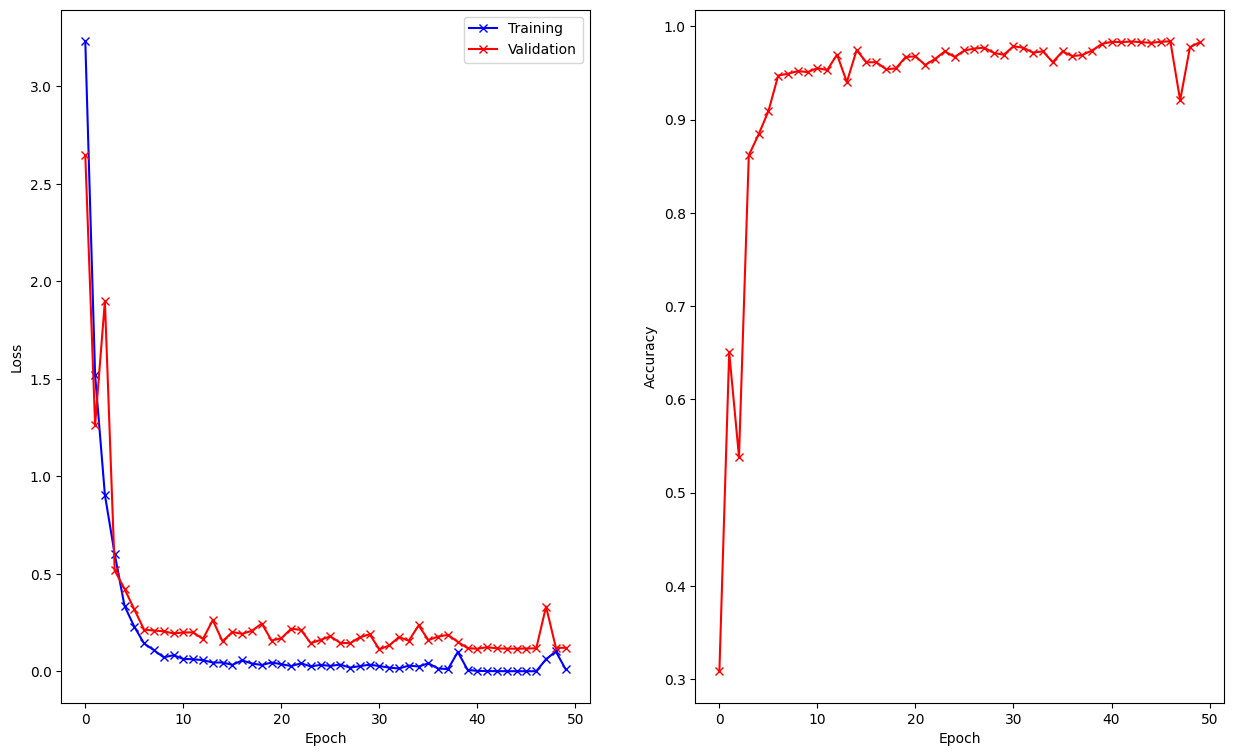

In [30]:
plot_history(resnet_history)

In [47]:
trained_model = final_fit(
    ResNet(),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    0.001,
    20,
    full_train_dataloader,
)

train time = 832.9619989572093


In [56]:
@torch.no_grad()
def predict(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    prediction = []
    for images in data_loader:
        images = images.to(device)
        outputs = model(images)
        _, labels = torch.max(outputs.data, 1)
        prediction.append(labels.cpu())
    return torch.cat(prediction).numpy()

In [57]:
labels = predict(test_dataloader, trained_model)

In [58]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [59]:
decoded_labels = label_encoder.inverse_transform(labels)

In [60]:
test_filenames = ['_'.join(path.name.split('_')[:-1]) for path in test_dataset.files_path]

In [61]:
pd.DataFrame({"true": test_filenames, "pred": decoded_labels})

,true,pred
0,abraham_grampa_simpson,abraham_grampa_simpson
1,abraham_grampa_simpson,abraham_grampa_simpson
2,abraham_grampa_simpson,abraham_grampa_simpson
3,abraham_grampa_simpson,abraham_grampa_simpson
4,abraham_grampa_simpson,abraham_grampa_simpson
...,...,...
985,sideshow_bob,sideshow_bob
986,sideshow_bob,sideshow_bob
987,sideshow_bob,sideshow_bob
988,sideshow_bob,sideshow_bob


In [62]:
from sklearn.metrics import accuracy_score

f1_score(test_filenames, decoded_labels, average="weighted")

0.9949390898685829

In [63]:
accuracy_score(test_filenames, decoded_labels)

0.9949494949494949